# regression_part_1_linear_regression

## Data import and test

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold


#Martim added imports from week 8
from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge


In [69]:
name_data_file="heart_failure_clinical_records_dataset"

data = pd.read_csv(f"../../raw_data/{name_data_file}.csv", na_values=["?"])

In [70]:
data

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


## Data Processing

In [71]:
# continuous and binary columns
continuous_cols = [
    "age",
    "creatinine_phosphokinase", 
    "ejection_fraction",
    "platelets",
    "serum_creatinine",
    "serum_sodium",
]
binary_cols = ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking", "DEATH_EVENT"]

In [72]:
# Predictors and target
y = data["time"]
X = data.drop(columns=["time"])  # remove target

## Log transform of CDK column

In [73]:
# Log-transform: creatinine_phosphokinase column
X["creatinine_phosphokinase"] = np.log1p(X["creatinine_phosphokinase"])

#### check data

In [74]:
X

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,DEATH_EVENT
0,75.0,0,6.368187,0,20,1,265000.00,1.9,130,1,0,1
1,55.0,0,8.969796,0,38,0,263358.03,1.1,136,1,0,1
2,65.0,0,4.990433,0,20,0,162000.00,1.3,129,1,1,1
3,50.0,1,4.718499,0,20,0,210000.00,1.9,137,1,0,1
4,65.0,1,5.081404,1,20,0,327000.00,2.7,116,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,4.127134,1,38,1,155000.00,1.1,143,1,1,0
295,55.0,0,7.507141,0,38,0,270000.00,1.2,139,0,0,0
296,45.0,0,7.630947,1,60,0,742000.00,0.8,138,0,0,0
297,45.0,0,7.789040,0,38,0,140000.00,1.4,140,1,1,0


## Regularization parameter λ and Generalization Error

### with DEATH_EVENT

#### λ range

===== 10-fold CV (Ridge) — standardized continuous + binary =====
     lambda  train_mse_mean  train_mse_std  gen_mse_est  test_mse_std
   0.000100     3980.173730     102.896916  4331.814669    982.280624
   0.000174     3980.173730     102.896916  4331.814550    982.280626
   0.000304     3980.173730     102.896916  4331.814344    982.280629
   0.000530     3980.173730     102.896916  4331.813984    982.280634
   0.000924     3980.173730     102.896916  4331.813357    982.280644
   0.001610     3980.173730     102.896916  4331.812263    982.280660
   0.002807     3980.173730     102.896916  4331.810356    982.280688
   0.004894     3980.173731     102.896917  4331.807032    982.280738
   0.008532     3980.173733     102.896917  4331.801238    982.280824
   0.014874     3980.173738     102.896917  4331.791141    982.280975
   0.025929     3980.173754     102.896917  4331.773547    982.281238
   0.045204     3980.173803     102.896917  4331.742904    982.281700
   0.078805     3980.173

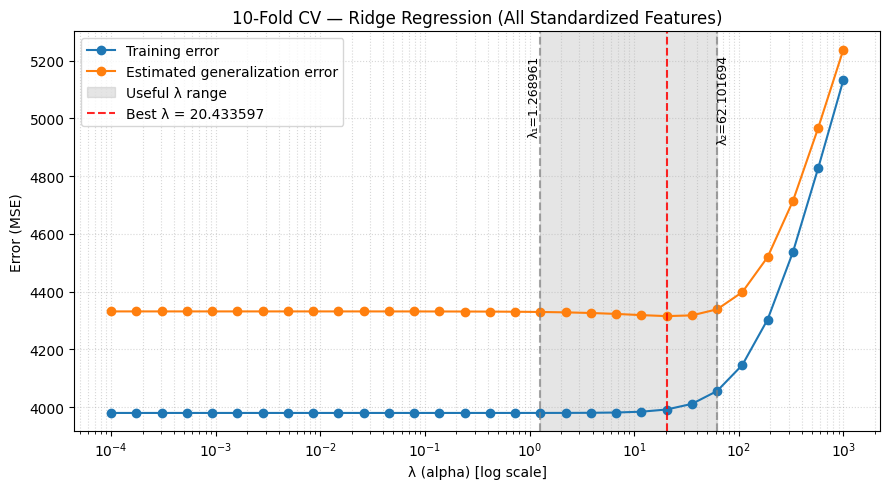


===== Coefficients (Final Ridge Model, All Standardized Features) =====
                 feature  coef_std_scale
             DEATH_EVENT      -37.682742
     high_blood_pressure      -10.593893
                 anaemia       -6.392951
       ejection_fraction       -5.977492
creatinine_phosphokinase        5.398770
                     age       -4.865411
                     sex       -2.616183
                 smoking       -2.180003
               platelets       -1.044048
                diabetes        1.040991
            serum_sodium        1.012933
        serum_creatinine        0.871220


In [75]:
# Cross-validation setup (Algorithm 5)
K = 10  # number of folds
kf = KFold(n_splits=K, shuffle=True, random_state=42)
lambdas = np.logspace(-4, 3, 30)  # λ grid (10^-4 to 10^3)

# Containers for storing CV results
train_err_mean, train_err_std = [], []
gen_err_est, test_err_std = [], []

# Helper function for z-score standardization (continuous + binary)
def standardize_features(X_train_df, X_test_df, cont_cols, bin_cols):
    """
    Standardize both continuous and binary variables using statistics
    computed from the training fold only.

    Transformation: X' = (X - μ_train) / σ_train
    for each feature j (continuous or binary).
    """
    all_cols = cont_cols + bin_cols

    mu = X_train_df[all_cols].mean(axis=0)
    sigma = X_train_df[all_cols].std(axis=0, ddof=0).replace(0, 1.0)

    X_train_std, X_test_std = X_train_df.copy(), X_test_df.copy()
    for X_ in [X_train_std, X_test_std]:
        X_[all_cols] = X_[all_cols].astype("float64")
        X_.loc[:, all_cols] = (X_[all_cols] - mu) / sigma

    return X_train_std, X_test_std

# K-fold cross-validation loop across λ values
N_total = len(X)

for lam in lambdas:
    fold_train_errs, fold_test_errs, fold_weights = [], [], []

    for train_idx, test_idx in kf.split(X, y):
        # Split the data into training and test folds
        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Standardize both continuous and binary variables
        X_train, X_test = standardize_features(X_train, X_test, continuous_cols, binary_cols)

        # Fit Ridge regression with current λ
        model = Ridge(alpha=lam, random_state=42)
        model.fit(X_train, y_train)

        # Compute training and test errors
        fold_train_errs.append(mean_squared_error(y_train, model.predict(X_train)))
        fold_test_errs.append(mean_squared_error(y_test, model.predict(X_test)))

        # Weight folds proportionally to their sample size
        fold_weights.append(len(test_idx) / N_total)

    # Aggregate results for this λ
    train_err_mean.append(np.mean(fold_train_errs))
    train_err_std.append(np.std(fold_train_errs, ddof=1))
    gen_err_est.append(np.sum(np.array(fold_weights) * np.array(fold_test_errs)))
    test_err_std.append(np.std(fold_test_errs, ddof=1))

# Compile CV results and find best λ
cv_table = pd.DataFrame({
    "lambda": lambdas,
    "train_mse_mean": train_err_mean,
    "train_mse_std": train_err_std,
    "gen_mse_est": gen_err_est,
    "test_mse_std": test_err_std,
})

best_idx = np.argmin(cv_table["gen_mse_est"])
best_lambda = cv_table.loc[best_idx, "lambda"]
best_gen_mse = cv_table.loc[best_idx, "gen_mse_est"]

# Define “useful λ range” using the 1-SE rule
gen = cv_table["gen_mse_est"].values
sd = cv_table["test_mse_std"].values
lams = cv_table["lambda"].values.astype(float)
K_eff = K

idx_min = int(np.argmin(gen))
best_lambda = float(lams[idx_min])
best_gen_mse = float(gen[idx_min])

# Definition parameters for λ interval
rel_tol = 0.01  # 1% relative tolerance
se_factor = 1   # 1-SE rule
max_span = 5    # maximum ±5 λ values around best λ

# Compute standard error and thresholds
se_min = sd[idx_min] / np.sqrt(K_eff)
thr_rel = best_gen_mse * (1.0 + rel_tol)
thr_se = best_gen_mse + se_factor * se_min
threshold = min(thr_rel, thr_se)

# Identify λ values within threshold
ok = np.where(gen <= threshold)[0]

# Find contiguous λ block containing the minimum
left_idx, right_idx = idx_min, idx_min
while (left_idx - 1) in ok:
    left_idx -= 1
while (right_idx + 1) in ok:
    right_idx += 1

# Restrict to ±5 around best λ
left_idx = max(left_idx, idx_min - max_span)
right_idx = min(right_idx, idx_min + max_span)

lambda_left, lambda_right = float(lams[left_idx]), float(lams[right_idx])
useful_range = (lambda_left, lambda_right)

print("===== 10-fold CV (Ridge) — standardized continuous + binary =====")
print(cv_table.to_string(index=False, float_format=lambda v: f"{v:.6f}"))
print(f"\nBest λ (alpha): {best_lambda:.6g}")
print(f"Estimated generalization error (MSE): {best_gen_mse:.6f}")
print(f"Useful λ range (strict): {useful_range[0]:.6f} → {useful_range[1]:.6f} "
      f"(rel_tol={rel_tol*100:.1f}%, se_factor={se_factor})")

# Plot generalization vs regularization curve
plt.figure(figsize=(9,5))
plt.semilogx(lams, cv_table["train_mse_mean"], marker="o", label="Training error")
plt.semilogx(lams, cv_table["gen_mse_est"], marker="o", label="Estimated generalization error")

# Highlight best λ and range
plt.axvspan(useful_range[0], useful_range[1], color="gray", alpha=0.2, label="Useful λ range")
plt.axvline(best_lambda, linestyle="--", color="red", alpha=0.85, label=f"Best λ = {best_lambda:.6f}")
plt.axvline(useful_range[0], linestyle="--", color="gray", alpha=0.7)
plt.axvline(useful_range[1], linestyle="--", color="gray", alpha=0.7)

y_top = plt.ylim()[1]
plt.text(useful_range[0], y_top*0.985, f"λ₁={useful_range[0]:.6f}", rotation=90, va='top', ha='right', fontsize=9)
plt.text(useful_range[1], y_top*0.985, f"λ₂={useful_range[1]:.6f}", rotation=90, va='top', ha='left', fontsize=9)

plt.xlabel("λ (alpha) [log scale]")
plt.ylabel("Error (MSE)")
plt.title("10-Fold CV — Ridge Regression (All Standardized Features)")
plt.legend()
plt.grid(True, which="both", ls=":", alpha=0.5)
plt.tight_layout()
plt.show()

# Refit final Ridge model on the full dataset
# ==============================================================
# Standardize all features (continuous + binary) using full-data stats
mu_full = X[continuous_cols + binary_cols].mean(axis=0)
sigma_full = X[continuous_cols + binary_cols].std(axis=0, ddof=0).replace(0, 1.0)

X_std_full = X.copy()
X_std_full[continuous_cols + binary_cols] = X_std_full[continuous_cols + binary_cols].astype("float64")
X_std_full.loc[:, continuous_cols + binary_cols] = (X_std_full[continuous_cols + binary_cols] - mu_full) / sigma_full

# Fit Ridge model on full standardized dataset
best_model = Ridge(alpha=best_lambda, random_state=42)
best_model.fit(X_std_full, y)

# Show final coefficients (on standardized scale)
coef_table = pd.DataFrame({
    "feature": X_std_full.columns,
    "coef_std_scale": best_model.coef_
}).sort_values("coef_std_scale", key=np.abs, ascending=False)

print("\n===== Coefficients (Final Ridge Model, All Standardized Features) =====")
print(coef_table.to_string(index=False, float_format=lambda v: f"{v:.6f}"))

#### How the model computes y for a given x:

In [76]:
# Coefficient table with interpretation units
coef_df = pd.DataFrame({
    "feature": X_std_full.columns,
    "coef": best_model.coef_
})
coef_df["type"] = np.where(coef_df["feature"].isin(continuous_cols), "continuous", "binary")

# For continuous: a +1 SD change -> +coef days; for binary: 0→1 -> +coef days
coef_df["effect_unit"] = np.where(
    coef_df["type"] == "continuous",
    "per +1 SD (z-scored)",
    "0→1 change"
)

# Sort by absolute effect size
coef_df = coef_df.sort_values("coef", key=np.abs, ascending=False).reset_index(drop=True)

print("\n=== Coefficients and interpretation units ===")
print(coef_df.to_string(index=False, float_format=lambda v: f"{v:.6f}"))

# Separate clearly positive and negative drivers
top_positive = coef_df[coef_df["coef"] > 0].sort_values("coef", ascending=False).head()
top_negative = coef_df[coef_df["coef"] < 0].sort_values("coef", ascending=True).head()

print("\nTop positive drivers (increase y):")
print(top_positive.to_string(index=False))

print("\nTop negative drivers (decrease y):")
print(top_negative.to_string(index=False))


=== Coefficients and interpretation units ===
                 feature       coef       type          effect_unit
             DEATH_EVENT -37.682742     binary           0→1 change
     high_blood_pressure -10.593893     binary           0→1 change
                 anaemia  -6.392951     binary           0→1 change
       ejection_fraction  -5.977492 continuous per +1 SD (z-scored)
creatinine_phosphokinase   5.398770 continuous per +1 SD (z-scored)
                     age  -4.865411 continuous per +1 SD (z-scored)
                     sex  -2.616183     binary           0→1 change
                 smoking  -2.180003     binary           0→1 change
               platelets  -1.044048 continuous per +1 SD (z-scored)
                diabetes   1.040991     binary           0→1 change
            serum_sodium   1.012933 continuous per +1 SD (z-scored)
        serum_creatinine   0.871220 continuous per +1 SD (z-scored)

Top positive drivers (increase y):
                 feature     coef

#### Example prediction

In [77]:
# --- Pick an example patient ---
example_idx = 0
example_raw = X.iloc[example_idx]
true_y = data.loc[example_idx, "time"]

def predict_from_raw_row(raw_row: pd.Series) -> float:
    """
    Predict the expected follow-up time (ŷ) for a new patient (raw_row).
    The transformations mirror those used during training.
    """
    x = raw_row.copy()

    # 1) Apply the same feature transformation as in training
    x["creatinine_phosphokinase"] = np.log1p(x["creatinine_phosphokinase"])

    # 2) Build DataFrame with the same column order as the training set
    x_df = pd.DataFrame([x], columns=X_std_full.columns)

    # 3) Ensure continuous columns are float
    x_df[continuous_cols] = x_df[continuous_cols].astype("float64")

    # 4) Standardize continuous columns using full-dataset stats
    x_df.loc[:, continuous_cols] = (x_df[continuous_cols] - mu_full) / sigma_full

    # 5) Predict using the trained ridge model
    y_hat = best_model.predict(x_df)[0]
    return float(y_hat)

# --- Predict using the same function ---
y_hat_example = predict_from_raw_row(example_raw)

# --- Print results side by side ---
print(f"\n=== Example prediction (patient index {example_idx}) ===")
print(f"True follow-up time (y):      {true_y:.2f} days")
print(f"Predicted follow-up (ŷ):      {y_hat_example:.2f} days")
print(f"Prediction error:             {y_hat_example - true_y:+.2f} days\n")

# --- Algebraic expression of the Ridge model ---
print("=== Algebraic form of the final Ridge Regression model ===\n")

intercept = best_model.intercept_
coefs = best_model.coef_

# Express model as: ŷ = intercept + Σ w_i * x_i
expression = "ŷ = {:.3f}".format(intercept)
for feat, coef in zip(X_std_full.columns, coefs):
    sign = "+" if coef >= 0 else "-"
    expression += f" {sign} {abs(coef):.3f}·{feat}"
print(expression + "\n")

# --- Contribution breakdown for this patient ---
# Build transformed version of the row (standardized like training)
x = example_raw.copy()
x["creatinine_phosphokinase"] = np.log1p(x["creatinine_phosphokinase"])
x_df = pd.DataFrame([x], columns=X_std_full.columns)
x_df[continuous_cols] = x_df[continuous_cols].astype("float64")
x_df.loc[:, continuous_cols] = (x_df[continuous_cols] - mu_full) / sigma_full

# Compute individual contributions
contrib = x_df.values[0] * coefs
contrib_df = pd.DataFrame({
    "feature": X_std_full.columns,
    "x_value": x_df.values[0],
    "coef": coefs,
    "contribution (coef*x)": contrib
})
contrib_df["abs_contribution"] = contrib_df["contribution (coef*x)"].abs()
contrib_df = contrib_df.sort_values("abs_contribution", ascending=False)

print("=== Feature contributions to prediction ===")
print(contrib_df[["feature", "x_value", "coef", "contribution (coef*x)"]]
      .to_string(index=False, float_format=lambda v: f"{v:.3f}"))


=== Example prediction (patient index 0) ===
True follow-up time (y):      4.00 days
Predicted follow-up (ŷ):      64.03 days
Prediction error:             +60.03 days

=== Algebraic form of the final Ridge Regression model ===

ŷ = 130.261 - 4.865·age - 6.393·anaemia + 5.399·creatinine_phosphokinase + 1.041·diabetes - 5.977·ejection_fraction - 10.594·high_blood_pressure - 1.044·platelets + 0.871·serum_creatinine + 1.013·serum_sodium - 2.616·sex - 2.180·smoking - 37.683·DEATH_EVENT

=== Feature contributions to prediction ===
                 feature  x_value    coef  contribution (coef*x)
             DEATH_EVENT    1.000 -37.683                -37.683
creatinine_phosphokinase   -3.253   5.399                -17.565
     high_blood_pressure    1.000 -10.594                -10.594
       ejection_fraction   -1.531  -5.977                  9.149
                     age    1.193  -4.865                 -5.804
                     sex    1.000  -2.616                 -2.616
            

### without DEATH_EVENT

#### X feature transformation

In [78]:
# Remove variable in study 
X = X.drop(columns=["DEATH_EVENT"])

#### λ range

===== 10-fold CV (Ridge) — standardized continuous + binary =====
     lambda  train_mse_mean  train_mse_std  gen_mse_est  test_mse_std
   0.000100     5268.966820     154.341549  5754.331989   1460.483831
   0.000174     5268.966820     154.341549  5754.331826   1460.483615
   0.000304     5268.966820     154.341549  5754.331542   1460.483238
   0.000530     5268.966820     154.341549  5754.331048   1460.482581
   0.000924     5268.966820     154.341549  5754.330186   1460.481435
   0.001610     5268.966820     154.341549  5754.328683   1460.479437
   0.002807     5268.966820     154.341549  5754.326062   1460.475955
   0.004894     5268.966820     154.341549  5754.321494   1460.469885
   0.008532     5268.966820     154.341549  5754.313531   1460.459303
   0.014874     5268.966821     154.341549  5754.299650   1460.440855
   0.025929     5268.966825     154.341549  5754.275454   1460.408698
   0.045204     5268.966835     154.341548  5754.233284   1460.352645
   0.078805     5268.966

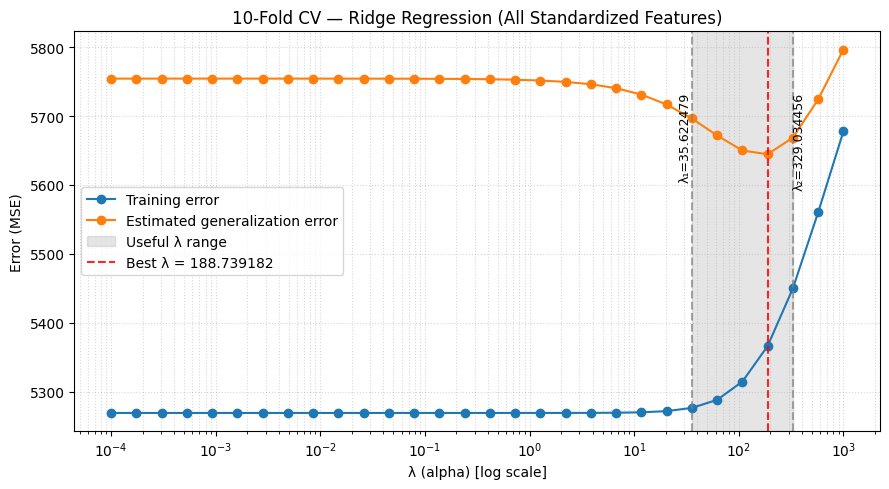


===== Coefficients (Final Ridge Model, All Standardized Features) =====
                 feature  coef_std_scale
                     age       -9.028275
     high_blood_pressure       -8.745263
                 anaemia       -5.712993
        serum_creatinine       -5.566118
            serum_sodium        3.381319
creatinine_phosphokinase        2.822798
       ejection_fraction        2.168132
                 smoking       -1.392447
                diabetes        0.726008
                     sex       -0.607658
               platelets       -0.141740


In [80]:
# Cross-validation setup (Algorithm 5)
K = 10  # number of folds
kf = KFold(n_splits=K, shuffle=True, random_state=42)
lambdas = np.logspace(-4, 3, 30)  # λ grid (10^-4 to 10^3)

# Containers for storing CV results
train_err_mean, train_err_std = [], []
gen_err_est, test_err_std = [], []

# Helper function for z-score standardization (continuous + binary)
def standardize_features(X_train_df, X_test_df, cont_cols, bin_cols):
    """
    Standardize both continuous and binary variables using statistics
    computed from the training fold only.

    Transformation: X' = (X - μ_train) / σ_train
    for each feature j (continuous or binary).
    """
    all_cols = cont_cols + bin_cols

    mu = X_train_df[all_cols].mean(axis=0)
    sigma = X_train_df[all_cols].std(axis=0, ddof=0).replace(0, 1.0)

    X_train_std, X_test_std = X_train_df.copy(), X_test_df.copy()
    for X_ in [X_train_std, X_test_std]:
        X_[all_cols] = X_[all_cols].astype("float64")
        X_.loc[:, all_cols] = (X_[all_cols] - mu) / sigma

    return X_train_std, X_test_std

# K-fold cross-validation loop across λ values
N_total = len(X)

for lam in lambdas:
    fold_train_errs, fold_test_errs, fold_weights = [], [], []

    for train_idx, test_idx in kf.split(X, y):
        # Split the data into training and test folds
        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Standardize both continuous and binary variables
        X_train, X_test = standardize_features(X_train, X_test, continuous_cols, binary_cols)

        # Fit Ridge regression with current λ
        model = Ridge(alpha=lam, random_state=42)
        model.fit(X_train, y_train)

        # Compute training and test errors
        fold_train_errs.append(mean_squared_error(y_train, model.predict(X_train)))
        fold_test_errs.append(mean_squared_error(y_test, model.predict(X_test)))

        # Weight folds proportionally to their sample size
        fold_weights.append(len(test_idx) / N_total)

    # Aggregate results for this λ
    train_err_mean.append(np.mean(fold_train_errs))
    train_err_std.append(np.std(fold_train_errs, ddof=1))
    gen_err_est.append(np.sum(np.array(fold_weights) * np.array(fold_test_errs)))
    test_err_std.append(np.std(fold_test_errs, ddof=1))

# Compile CV results and find best λ
cv_table = pd.DataFrame({
    "lambda": lambdas,
    "train_mse_mean": train_err_mean,
    "train_mse_std": train_err_std,
    "gen_mse_est": gen_err_est,
    "test_mse_std": test_err_std,
})

best_idx = np.argmin(cv_table["gen_mse_est"])
best_lambda = cv_table.loc[best_idx, "lambda"]
best_gen_mse = cv_table.loc[best_idx, "gen_mse_est"]

# Define “useful λ range” using the 1-SE rule
gen = cv_table["gen_mse_est"].values
sd = cv_table["test_mse_std"].values
lams = cv_table["lambda"].values.astype(float)
K_eff = K

idx_min = int(np.argmin(gen))
best_lambda = float(lams[idx_min])
best_gen_mse = float(gen[idx_min])

# Define parameters for λ interval
rel_tol = 0.01  # 1% relative tolerance
se_factor = 1   # 1-SE rule
max_span = 5    # maximum ±5 λ values around best λ

# Compute standard error and thresholds
se_min = sd[idx_min] / np.sqrt(K_eff)
thr_rel = best_gen_mse * (1.0 + rel_tol)
thr_se = best_gen_mse + se_factor * se_min
threshold = min(thr_rel, thr_se)

# Identify λ values within threshold
ok = np.where(gen <= threshold)[0]

# Find contiguous λ block containing the minimum
left_idx, right_idx = idx_min, idx_min
while (left_idx - 1) in ok:
    left_idx -= 1
while (right_idx + 1) in ok:
    right_idx += 1

# Restrict to ±5 around best λ
left_idx = max(left_idx, idx_min - max_span)
right_idx = min(right_idx, idx_min + max_span)

lambda_left, lambda_right = float(lams[left_idx]), float(lams[right_idx])
useful_range = (lambda_left, lambda_right)

print("===== 10-fold CV (Ridge) — standardized continuous + binary =====")
print(cv_table.to_string(index=False, float_format=lambda v: f"{v:.6f}"))
print(f"\nBest λ (alpha): {best_lambda:.6g}")
print(f"Estimated generalization error (MSE): {best_gen_mse:.6f}")
print(f"Useful λ range (strict): {useful_range[0]:.6f} → {useful_range[1]:.6f} "
      f"(rel_tol={rel_tol*100:.1f}%, se_factor={se_factor})")

# Plot generalization vs regularization curve
plt.figure(figsize=(9,5))
plt.semilogx(lams, cv_table["train_mse_mean"], marker="o", label="Training error")
plt.semilogx(lams, cv_table["gen_mse_est"], marker="o", label="Estimated generalization error")

# Highlight best λ and range
plt.axvspan(useful_range[0], useful_range[1], color="gray", alpha=0.2, label="Useful λ range")
plt.axvline(best_lambda, linestyle="--", color="red", alpha=0.85, label=f"Best λ = {best_lambda:.6f}")
plt.axvline(useful_range[0], linestyle="--", color="gray", alpha=0.7)
plt.axvline(useful_range[1], linestyle="--", color="gray", alpha=0.7)

y_top = plt.ylim()[1]
plt.text(useful_range[0], y_top*0.985, f"λ₁={useful_range[0]:.6f}", rotation=90, va='top', ha='right', fontsize=9)
plt.text(useful_range[1], y_top*0.985, f"λ₂={useful_range[1]:.6f}", rotation=90, va='top', ha='left', fontsize=9)

plt.xlabel("λ (alpha) [log scale]")
plt.ylabel("Error (MSE)")
plt.title("10-Fold CV — Ridge Regression (All Standardized Features)")
plt.legend()
plt.grid(True, which="both", ls=":", alpha=0.5)
plt.tight_layout()
plt.show()

# Refit final Ridge model on the full dataset
# ==============================================================
# Standardize all features (continuous + binary) using full-data stats
mu_full = X[continuous_cols + binary_cols].mean(axis=0)
sigma_full = X[continuous_cols + binary_cols].std(axis=0, ddof=0).replace(0, 1.0)

X_std_full = X.copy()
X_std_full[continuous_cols + binary_cols] = X_std_full[continuous_cols + binary_cols].astype("float64")
X_std_full.loc[:, continuous_cols + binary_cols] = (X_std_full[continuous_cols + binary_cols] - mu_full) / sigma_full

# Fit Ridge model on full standardized dataset
best_model = Ridge(alpha=best_lambda, random_state=42)
best_model.fit(X_std_full, y)

# Show final coefficients (on standardized scale)
coef_table = pd.DataFrame({
    "feature": X_std_full.columns,
    "coef_std_scale": best_model.coef_
}).sort_values("coef_std_scale", key=np.abs, ascending=False)

print("\n===== Coefficients (Final Ridge Model, All Standardized Features) =====")
print(coef_table.to_string(index=False, float_format=lambda v: f"{v:.6f}"))

#### How the model computes y for a given x:

In [81]:
# Coefficient table with interpretation units
coef_df = pd.DataFrame({
    "feature": X_std_full.columns,
    "coef": best_model.coef_
})
coef_df["type"] = np.where(coef_df["feature"].isin(continuous_cols), "continuous", "binary")

# For continuous: a +1 SD change -> +coef days; for binary: 0→1 -> +coef days
coef_df["effect_unit"] = np.where(
    coef_df["type"] == "continuous",
    "per +1 SD (z-scored)",
    "0→1 change"
)

# Sort by absolute effect size
coef_df = coef_df.sort_values("coef", key=np.abs, ascending=False).reset_index(drop=True)

print("\n=== Coefficients and interpretation units ===")
print(coef_df.to_string(index=False, float_format=lambda v: f"{v:.6f}"))

# Separate clearly positive and negative drivers
top_positive = coef_df[coef_df["coef"] > 0].sort_values("coef", ascending=False).head()
top_negative = coef_df[coef_df["coef"] < 0].sort_values("coef", ascending=True).head()

print("\nTop positive drivers (increase y):")
print(top_positive.to_string(index=False))

print("\nTop negative drivers (decrease y):")
print(top_negative.to_string(index=False))


=== Coefficients and interpretation units ===
                 feature      coef       type          effect_unit
                     age -9.028275 continuous per +1 SD (z-scored)
     high_blood_pressure -8.745263     binary           0→1 change
                 anaemia -5.712993     binary           0→1 change
        serum_creatinine -5.566118 continuous per +1 SD (z-scored)
            serum_sodium  3.381319 continuous per +1 SD (z-scored)
creatinine_phosphokinase  2.822798 continuous per +1 SD (z-scored)
       ejection_fraction  2.168132 continuous per +1 SD (z-scored)
                 smoking -1.392447     binary           0→1 change
                diabetes  0.726008     binary           0→1 change
                     sex -0.607658     binary           0→1 change
               platelets -0.141740 continuous per +1 SD (z-scored)

Top positive drivers (increase y):
                 feature     coef       type          effect_unit
            serum_sodium 3.381319 continuous pe

#### Example prediction

In [82]:
# --- Pick an example patient ---
example_idx = 100
example_raw = X.iloc[example_idx]
true_y = data.loc[example_idx, "time"]
all_cols = continuous_cols + binary_cols

def predict_from_raw_row(raw_row: pd.Series) -> float:
    """
    Predict the expected follow-up time (ŷ) for a new patient (raw_row).
    The transformations mirror those used during training, including
    log-transform and standardization of both continuous and binary variables.
    """
    x = raw_row.copy()

    # 1) Apply the same log-transform as in training
    x["creatinine_phosphokinase"] = np.log1p(x["creatinine_phosphokinase"])

    # 2) Build a one-row DataFrame matching the training feature order
    x_df = pd.DataFrame([x], columns=X_std_full.columns)

    # 3) Ensure continuous and binary columns are numeric
    all_cols = continuous_cols + binary_cols
    x_df[all_cols] = x_df[all_cols].astype("float64")

    # 4) Apply standardization (same as in full-dataset fitting)
    x_df.loc[:, all_cols] = (x_df[all_cols] - mu_full[all_cols]) / sigma_full[all_cols]

    # 5) Predict using the trained Ridge model
    y_hat = best_model.predict(x_df)[0]
    return float(y_hat)


# --- Predict using the same function ---
y_hat_example = predict_from_raw_row(example_raw)

# --- Print results side by side ---
print(f"\n=== Example prediction (patient index {example_idx}) ===")
print(f"True follow-up time (y):      {true_y:.2f} days")
print(f"Predicted follow-up (ŷ):      {y_hat_example:.2f} days")
print(f"Prediction error:             {y_hat_example - true_y:+.2f} days\n")

# --- Algebraic expression of the Ridge model ---
print("=== Algebraic form of the final Ridge Regression model ===\n")

intercept = best_model.intercept_
coefs = best_model.coef_

# Express model as: ŷ = intercept + Σ w_i * x_i
expression = f"ŷ = {intercept:.3f}"
for feat, coef in zip(X_std_full.columns, coefs):
    sign = "+" if coef >= 0 else "-"
    expression += f" {sign} {abs(coef):.3f}·{feat}"
print(expression + "\n")

# --- Contribution breakdown for this patient ---
# Apply same preprocessing to example row
x = example_raw.copy()
x["creatinine_phosphokinase"] = np.log1p(x["creatinine_phosphokinase"])
x_df = pd.DataFrame([x], columns=X_std_full.columns)
x_df[all_cols] = x_df[all_cols].astype("float64")
x_df.loc[:, all_cols] = (x_df[all_cols] - mu_full[all_cols]) / sigma_full[all_cols]

# Compute individual feature contributions (β_j * x_j)
contrib = x_df.values[0] * coefs
contrib_df = pd.DataFrame({
    "feature": X_std_full.columns,
    "x_value": x_df.values[0],
    "coef": coefs,
    "contribution (coef*x)": contrib
})
contrib_df["abs_contribution"] = contrib_df["contribution (coef*x)"].abs()
contrib_df = contrib_df.sort_values("abs_contribution", ascending=False)

print("=== Feature contributions to prediction ===")
print(contrib_df[["feature", "x_value", "coef", "contribution (coef*x)"]]
      .to_string(index=False, float_format=lambda v: f"{v:.3f}"))


=== Example prediction (patient index 100) ===
True follow-up time (y):      87.00 days
Predicted follow-up (ŷ):      119.94 days
Prediction error:             +32.94 days

=== Algebraic form of the final Ridge Regression model ===

ŷ = 130.261 - 9.028·age - 5.713·anaemia + 2.823·creatinine_phosphokinase + 0.726·diabetes + 2.168·ejection_fraction - 8.745·high_blood_pressure - 0.142·platelets - 5.566·serum_creatinine + 3.381·serum_sodium - 0.608·sex - 1.392·smoking

=== Feature contributions to prediction ===
                 feature  x_value   coef  contribution (coef*x)
creatinine_phosphokinase   -3.335  2.823                 -9.413
                 anaemia    1.148 -5.713                 -6.558
     high_blood_pressure   -0.736 -8.745                  6.434
            serum_sodium    0.993  3.381                  3.358
                     age    0.351 -9.028                 -3.167
       ejection_fraction   -1.107  2.168                 -2.401
        serum_creatinine   -0.285 -5.

## 4 setup comparation:

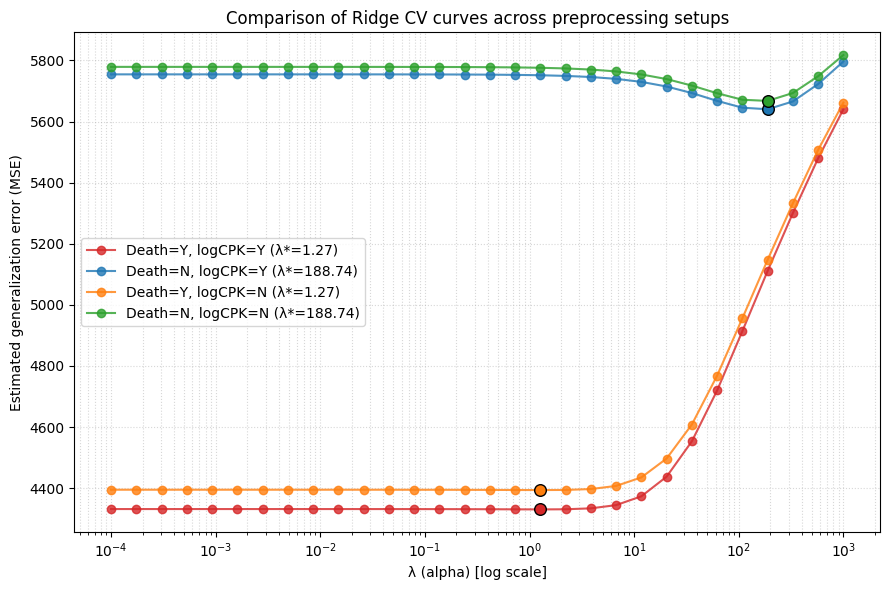

In [ ]:
# COMBINED PLOT: Estimated Generalization Error (all scenarios)

def run_ridge_cv_get_curve(X, y, continuous_cols, binary_cols, log_cpk=True, drop_death=False):
    """
    Performs 10-fold CV Ridge regression and returns the generalization error curve.
    Includes standardization of both continuous and binary features.
    """
    X_proc = X.copy()

    # Drop DEATH_EVENT if needed
    if drop_death and "DEATH_EVENT" in X_proc.columns:
        X_proc = X_proc.drop(columns=["DEATH_EVENT"])

    # Log-transform CPK
    if log_cpk:
        X_proc["creatinine_phosphokinase"] = np.log1p(X_proc["creatinine_phosphokinase"])

    # Combine all columns and compute z-score stats
    all_cols = [c for c in continuous_cols + binary_cols if c in X_proc.columns]
    mu_full = X_proc[all_cols].mean(axis=0)
    sigma_full = X_proc[all_cols].std(axis=0, ddof=0).replace(0, 1.0)

    # Standardize both continuous and binary columns
    X_std = X_proc.copy()
    X_std[all_cols] = X_std[all_cols].astype("float64")
    X_std.loc[:, all_cols] = (X_std[all_cols] - mu_full) / sigma_full

    # 10-fold CV
    K = 10
    kf = KFold(n_splits=K, shuffle=True, random_state=42)
    lambdas = np.logspace(-4, 3, 30)
    gen_err_est = []

    N_total = len(X_std)
    for lam in lambdas:
        fold_test_errs, fold_weights = [], []
        for train_idx, test_idx in kf.split(X_std, y):
            X_train, X_test = X_std.iloc[train_idx], X_std.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            model = Ridge(alpha=lam, random_state=42)
            model.fit(X_train, y_train)

            mse_test = mean_squared_error(y_test, model.predict(X_test))
            fold_test_errs.append(mse_test)
            fold_weights.append(len(test_idx) / N_total)

        gen_err_est.append(np.sum(np.array(fold_weights) * np.array(fold_test_errs)))

    return np.array(lambdas), np.array(gen_err_est)


# scenarios
scenarios = {
    "Death=Y, logCPK=Y":  {"drop_death": False, "log_cpk": True,  "color": "tab:red"},
    "Death=N, logCPK=Y":  {"drop_death": True,  "log_cpk": True,  "color": "tab:blue"},
    "Death=Y, logCPK=N":  {"drop_death": False, "log_cpk": False, "color": "tab:orange"},
    "Death=N, logCPK=N":  {"drop_death": True,  "log_cpk": False, "color": "tab:green"},
}

plt.figure(figsize=(9, 6))

# Run all 4 scenarios and plot curves 
for label, cfg in scenarios.items():
    lambdas, gen_err = run_ridge_cv_get_curve(
        data.drop(columns=["time"]),
        data["time"],
        continuous_cols,
        binary_cols,
        log_cpk=cfg["log_cpk"],
        drop_death=cfg["drop_death"]
    )

    best_idx = np.argmin(gen_err)
    best_lambda = lambdas[best_idx]
    best_gen_mse = gen_err[best_idx]

    # Plot curve
    plt.semilogx(lambdas, gen_err, marker="o", label=f"{label} (λ*={best_lambda:.2f})", color=cfg["color"], alpha=0.8)
    plt.scatter(best_lambda, best_gen_mse, color=cfg["color"], edgecolor="k", s=70, zorder=5)

# Figure formatting 
plt.xlabel("λ (alpha) [log scale]")
plt.ylabel("Estimated generalization error (MSE)")
plt.title("Comparison of Ridge CV curves across preprocessing setups")
plt.legend()
plt.grid(True, which="both", ls=":", alpha=0.5)
plt.tight_layout()
plt.show()